In [1]:
#Imports
%matplotlib inline

#Imports
import pynbody
from matplotlib.pylab import *
import matplotlib.pylab as plt
import pynbody.plot.sph as sph
import numpy as np
from scipy import interpolate
import matplotlib.lines as mlines
import matplotlib.colors
from matplotlib.pyplot import figure, show, rc

#Tell notebook where my diskpy distribution is (the lazy way)
import os
sys.path.append('/astro/users/dflemin3/Desktop/diskpy')
sys.path.append('/astro/users/dflemin3/Desktop')

import diskpy
from diskpy.ICgen import *

#Typical plot parameters that make for pretty plots
plt.rcParams['figure.figsize'] = (10,6)
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=20, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 20.0

In [2]:
#Tell code where data is
cwd = '/astro/users/dflemin3/Desktop/onlyStars'
os.chdir(cwd)

In [3]:
#Initialize variables to be determined later
steps = 0
nSteps = 0
dDelta = 0

In [4]:
#Read in .param file and extract info I need

#Find param file if it exists
for file in os.listdir(cwd):
    if file.endswith(".param"):
        filename = file
        break
    else:
        filename = "Invalid"
        
#No file name so give warning before program dies
if filename == "Invalid":
    print "No .param file found!"

else:
    with open(filename) as f:
        lines = f.readlines()

    #Iterate over lines in param file, look for ones of interest
    for line in lines:
        line = str(line).rstrip('\n')

        #Look for file name
        if "achOutName" in line:
            line = line.lstrip('achOutName')
            line = line.lstrip()
            line = line.lstrip('=')
            line = line.lstrip()
            name = line

        #Look for iOutInterval
        if "iOutInterval" in line:
            line = line.lstrip('iOutInterval')
            line = line.lstrip()
            line = line.lstrip('=')
            line = line.lstrip()
            steps = int(line)

        #Look for number of steps
        if "nSteps" in line:
            line = line.lstrip('nSteps')
            line = line.lstrip()
            line = line.lstrip('=')
            line = line.lstrip()
            nSteps = int(line)

        #Look for dDelta
        if "dDelta" in line:
            line = line.lstrip('dDelta')
            line = line.lstrip()
            line = line.lstrip('=')
            line = line.lstrip()
            dDelta = float(line)
        
#close file
f.close()

In [5]:
#Given the variables just read in, compute how many output files I have to read in, then allocate data for the info I want
num = nSteps/steps + 1

#Now allocate numpy arrays to hold information I care about so I can plot and things

#Allocate space for orbital elements

orbElems = np.zeros((num,6))
comBinary = np.zeros((num,3))
comVelBinary = np.zeros((num,3))
mass = np.zeros((num,2))
time = np.linspace(0,dDelta/(2.0*np.pi)*nSteps,num)

#Int flags to select orbital elements
[e,a,inc,loan,w,nu] = [0,1,2,3,4,5]

In [6]:
%%capture
#Read in files, if I can't open a file, tell user why/which one
#Use capture to suppress stderr output
#First, check to see if I have an archive file for this data set.
#Look in the directory where data is!
#Assume if one exists, they all do

archiveName = name + "_archive.npz"

#Lazy, I don't want to un-indent things
if True or (not os.path.exists(archiveName)):
    #No archive file in directory, so load data from snaps
    #Read in initial conditions of the form name.std
    
    print "Loading snapshots, storing in {0} archive.".format(name)
    
    try:
        snap = name + ".std"
        s = pynbody.load(snap)
    except RuntimeError:
        print "No initial conditions found!  Was looking for {0}".format(snap)
    else:
        #Get binary stellar parameters
        x1 = s.stars[0]['pos']
        x2 = s.stars[1]['pos']
        v1 = s.stars[0]['vel']
        v2 = s.stars[1]['vel']
        m1 = s.stars[0]['mass']
        m2 = s.stars[1]['mass']
        mass[0,:] = [m1,m2]

        #Orbital Elements Calculations
        orbElems[0,:] = AddBinary.calcOrbitalElements(x1, x2, v1, v2, m1, m2)
        
        #Center of Mass calculations
        comBinary[0] = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=False)
        comVelBinary[0] = binaryUtils.computeVelocityCOM(s,starFlag=True,gasFlag=False)
        
    #end reading in ICs

    #Start counting other snapshots    
    i = 1

    while i < num:
        t = str(i*steps)
        pad = t.rjust(6, '0')
        snap = name + "." + pad
        try:
            s = pynbody.load(snap)
        except RuntimeError:
            print "No file found!  Was looking for {0}".format(snap)
            break
        else:
            #Get binary stellar parameters
            x1 = s.stars[0]['pos']
            x2 = s.stars[1]['pos']
            v1 = s.stars[0]['vel']
            v2 = s.stars[1]['vel']
            m1 = s.stars[0]['mass']
            m2 = s.stars[1]['mass']
            mass[i,:] = [m1,m2]

            #Orbital Element Calculations
            orbElems[i,:] = AddBinary.calcOrbitalElements(x1, x2, v1, v2, m1, m2)
            
            #Center of Mass calculations
            comBinary[i] = binaryUtils.computeCOM(s.stars,s.gas,starFlag=True,gasFlag=False)
            comVelBinary[i] = binaryUtils.computeVelocityCOM(s,starFlag=True,gasFlag=False)
            
            #Make plots?
            """
            pynbody.plot.generic.hist2d(s.gas['temp'],s.gas['p'].in_units('Pa'),xlogrange=True,ylogrange=True,
                           x_range=(2,3.8),y_range=(-5,3));
            plt.xlim(2,3.8)
            plt.ylim(-5,3)
            plt.title("{0}".format(time[i]),y=1.02)
            img_name = "controlP_vs_T." + str(i) + ".png"
            plt.savefig(img_name)
            plt.close()
            """
            
            i += 1

    
#If there is an archive, load data from past archive
else:
    print ""

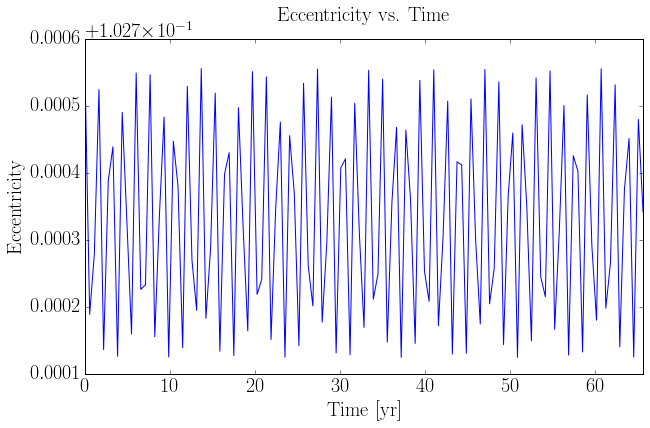

In [7]:
#Produce plot of e vs time
plt.plot(time,orbElems[:,e])
plt.ylabel("Eccentricity")
plt.xlabel("Time [yr]")
plt.xlim(time.min(),time.max())
plt.title("Eccentricity vs. Time",y=1.04)

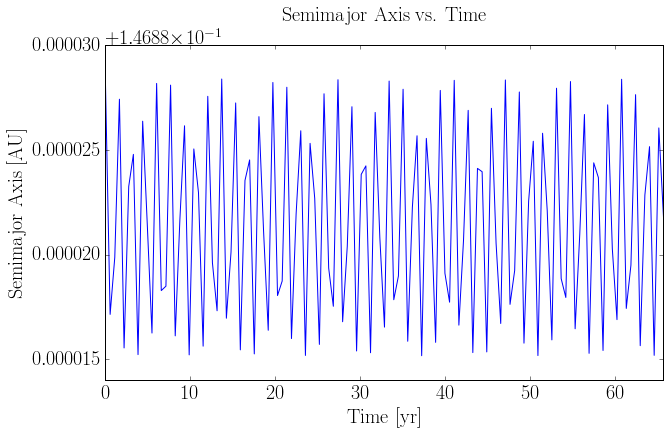

In [8]:
#Produce plot of a vs time
plt.plot(time,orbElems[:,a])
plt.ylabel("Semimajor Axis [AU]")
plt.xlabel("Time [yr]")
plt.xlim(time.min(),time.max())
plt.title("Semimajor Axis vs. Time",y=1.06)

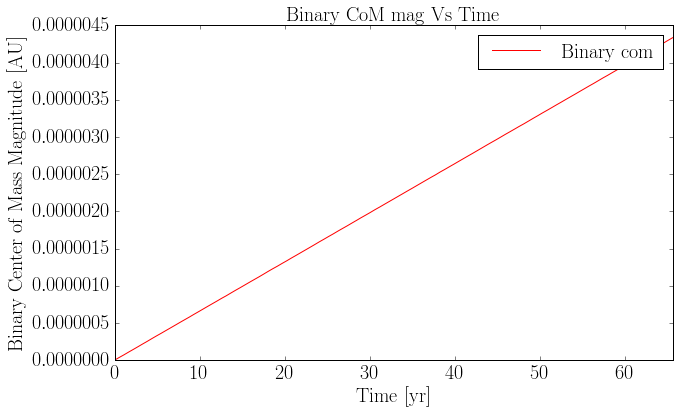

In [9]:
com_mag = np.sqrt(AddBinary.dotProduct(comBinary,comBinary))
plt.plot(time,com_mag,color='red',label='Binary com')
plt.xlabel("Time [yr]")
plt.ylabel("Binary Center of Mass Magnitude [AU]")
plt.xlim(time.min(),time.max())
plt.title("Binary CoM mag Vs Time")
plt.legend()  

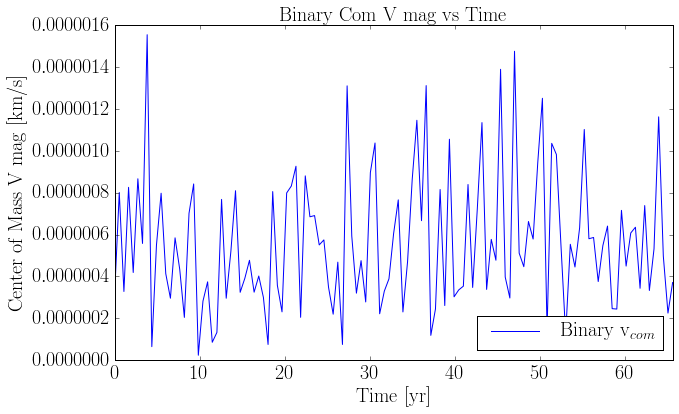

In [10]:
vcom_mag = np.sqrt(AddBinary.dotProduct(comVelBinary,comVelBinary))

plt.plot(time,vcom_mag,color='blue',label='Binary v$_{com}$')
plt.xlabel("Time [yr]")
plt.ylabel("Center of Mass V mag [km/s]")
plt.xlim(time.min(),time.max())
plt.title("Binary Com V mag vs Time")
plt.legend(loc = "lower right")  

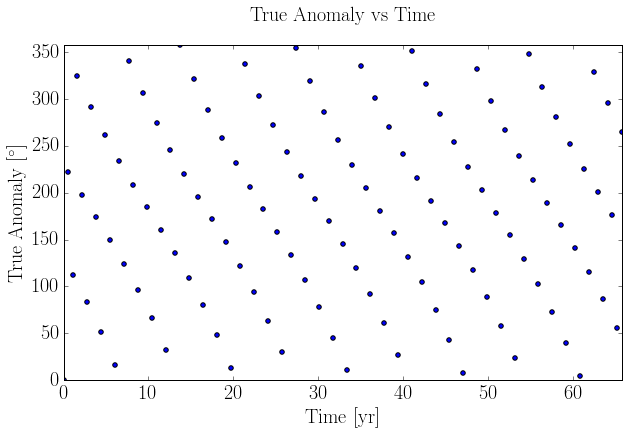

In [11]:
plt.scatter(time,orbElems[:,nu])

plt.xlabel("Time [yr]")
plt.ylim(np.min(orbElems[:,nu]),np.max(orbElems[:,nu]))
plt.xlim(time.min(),time.max())
plt.ylabel("True Anomaly [$^\circ$]")
plt.title("True Anomaly vs Time",y=1.06)

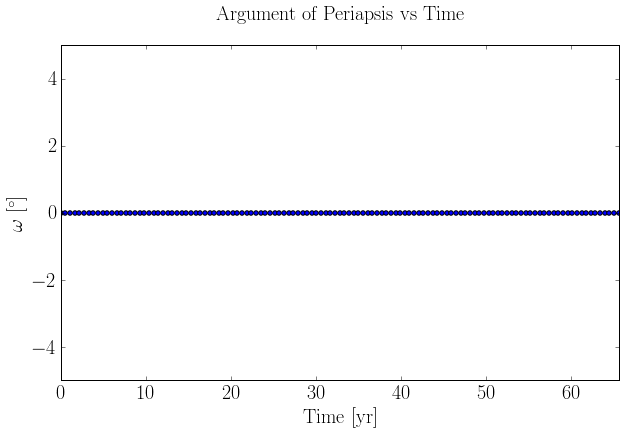

In [12]:
plt.scatter(time[0:],orbElems[0:,w])

plt.xlabel("Time [yr]")
plt.ylim(np.min(orbElems[0:,w]-5),np.max(orbElems[0:,w])+5)
plt.xlim(time.min(),time.max())
plt.ylabel(r"$\omega$ [$^\circ$]")
plt.title("Argument of Periapsis vs Time",y=1.06)

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/matplotlib/axes/_base.py:2809: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


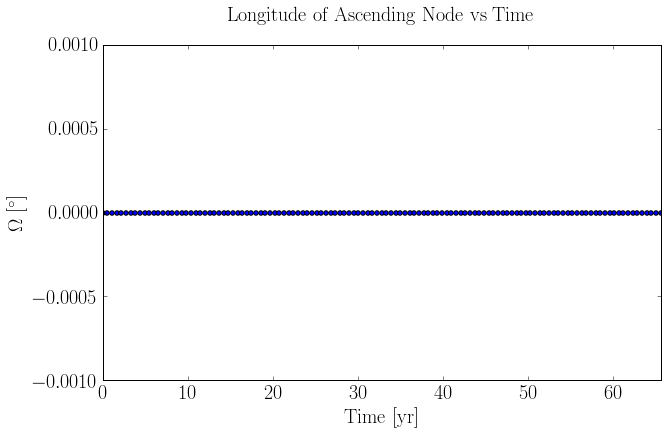

In [13]:
plt.scatter(time,orbElems[:,loan])

plt.xlabel("Time [yr]")
plt.ylim(np.min(orbElems[:,loan]),np.max(orbElems[:,loan]))
plt.xlim(time.min(),time.max())
plt.ylabel(r"$\Omega$ [$^\circ$]")
plt.title("Longitude of Ascending Node vs Time",y=1.06)

/astro/apps6/anaconda2.0/lib/python2.7/site-packages/matplotlib/axes/_base.py:2809: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


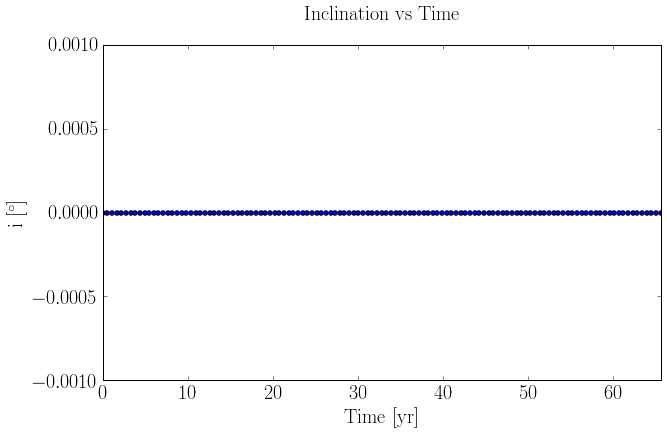

In [14]:
plt.scatter(time,orbElems[:,inc])

plt.xlabel("Time [yr]")
plt.ylim(0,np.max(orbElems[:,inc]))
plt.xlim(time.min(),time.max())
plt.ylabel(r"i [$^\circ$]")
plt.title("Inclination vs Time",y=1.06)

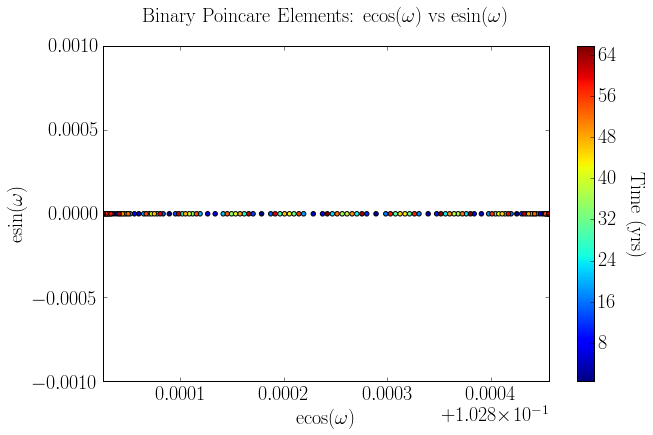

In [15]:
#Plot ecosw, esinw Poincare Elements (convert from degrees to radians!)
conv = np.pi/180.0
scat = plt.scatter(orbElems[1:,e]*np.cos(conv*orbElems[1:,w]),orbElems[1:,e]*np.sin(conv*orbElems[1:,w]),c=time[1:],cmap='jet')
cbar = plt.colorbar(scat)
cbar.set_label("Time (yrs)", labelpad=30, rotation=270)

#Make plot look nice
plt.xlim(min(orbElems[1:,e]*np.cos(conv*orbElems[1:,w])),max(orbElems[1:,e]*np.cos(conv*orbElems[1:,w])))
plt.ylim(min(orbElems[1:,e]*np.sin(conv*orbElems[1:,w])),max(orbElems[1:,e]*np.sin(conv*orbElems[1:,w])))
plt.title(r"Binary Poincare Elements: ecos($\omega$) vs esin($\omega$)",y=1.06)
plt.xlabel(r"ecos($\omega$)")
plt.ylabel(r"esin($\omega$)")
#plt.savefig("lateLowEccBinPoisElems.pdf",bbox_inches='tight')

In [16]:
print repr(time[:])
print repr(orbElems[:,e])
print repr(np.sqrt(AddBinary.dotProduct(comBinary,comBinary)))

array([  0.        ,   0.54709512,   1.09419023,   1.64128535,
         2.18838047,   2.73547558,   3.2825707 ,   3.82966582,
         4.37676094,   4.92385605,   5.47095117,   6.01804629,
         6.5651414 ,   7.11223652,   7.65933164,   8.20642675,
         8.75352187,   9.30061699,   9.8477121 ,  10.39480722,
        10.94190234,  11.48899745,  12.03609257,  12.58318769,
        13.13028281,  13.67737792,  14.22447304,  14.77156816,
        15.31866327,  15.86575839,  16.41285351,  16.95994862,
        17.50704374,  18.05413886,  18.60123397,  19.14832909,
        19.69542421,  20.24251932,  20.78961444,  21.33670956,
        21.88380468,  22.43089979,  22.97799491,  23.52509003,
        24.07218514,  24.61928026,  25.16637538,  25.71347049,
        26.26056561,  26.80766073,  27.35475584,  27.90185096,
        28.44894608,  28.99604119,  29.54313631,  30.09023143,
        30.63732655,  31.18442166,  31.73151678,  32.2786119 ,
        32.82570701,  33.37280213,  33.91989725,  34.46

In [22]:
time_1 = [   0.        ,    2.18838047,    4.37676094,    6.5651414 ,
          8.75352187,   10.94190234,   13.13028281,   15.31866327,
         17.50704374,   19.69542421,   21.88380468,   24.07218514,
         26.26056561,   28.44894608,   30.63732655,   32.82570701,
         35.01408748,   37.20246795,   39.39084842,   41.57922888,
         43.76760935,   45.95598982,   48.14437029,   50.33275075,
         52.52113122,   54.70951169,   56.89789216,   59.08627262,
         61.27465309,   63.46303356,   65.65141403,   67.83979449,
         70.02817496,   72.21655543,   74.4049359 ,   76.59331636,
         78.78169683,   80.9700773 ,   83.15845777,   85.34683823,
         87.5352187 ,   89.72359917,   91.91197964,   94.1003601 ,
         96.28874057,   98.47712104,  100.66550151,  102.85388197,
        105.04226244,  107.23064291,  109.41902338,  111.60740384,
        113.79578431,  115.98416478,  118.17254525,  120.36092571,
        122.54930618,  124.73768665,  126.92606712,  129.11444758,
        131.30282805,  133.49120852,  135.67958899,  137.86796945,
        140.05634992,  142.24473039,  144.43311086,  146.62149132,
        148.80987179,  150.99825226,  153.18663273,  155.37501319,
        157.56339366,  159.75177413,  161.9401546 ,  164.12853506,
        166.31691553,  168.505296  ,  170.69367647,  172.88205693,
        175.0704374 ,  177.25881787,  179.44719834,  181.6355788 ,
        183.82395927,  186.01233974,  188.20072021,  190.38910067,
        192.57748114,  194.76586161,  196.95424208,  199.14262254,
        201.33100301,  203.51938348,  205.70776395,  207.89614441,
        210.08452488,  212.27290535,  214.46128582,  216.64966628,
        218.83804675,  221.02642722,  223.21480769,  225.40318815,
        227.59156862,  229.77994909,  231.96832956,  234.15671002,
        236.34509049,  238.53347096,  240.72185143,  242.91023189,
        245.09861236,  247.28699283,  249.4753733 ,  251.66375376,
        253.85213423,  256.0405147 ,  258.22889517,  260.41727563,
        262.6056561 ]

ecc_1 = [ 0.10324994,  0.10508118,  0.10548395,  0.10510726,  0.10543238,
        0.10515401,  0.10536024,  0.10521851,  0.10528046,  0.1052952 ,
        0.10520539,  0.10537459,  0.10514389,  0.10544381,  0.10510085,
        0.10549044,  0.10507865,  0.105507  ,  0.10507832,  0.10549154,
        0.10509971,  0.1054459 ,  0.10514195,  0.1053773 ,  0.10520294,
        0.10529807,  0.10527759,  0.10522103,  0.10535742,  0.105156  ,
        0.10543006,  0.10510863,  0.10548252,  0.10508176,  0.10550615,
        0.10507651,  0.10549777,  0.10509309,  0.1054583 ,  0.105131  ,
        0.10539388,  0.10518809,  0.10531578,  0.1052603 ,  0.10523731,
        0.10533996,  0.10516897,  0.1054153 ,  0.10511743,  0.10547326,
        0.10508584,  0.10550357,  0.10507579,  0.10550232,  0.10508751,
        0.10546952,  0.10512081,  0.10540977,  0.10517394,  0.10533348,
        0.10524341,  0.10525407,  0.10532224,  0.10518282,  0.10539974,
        0.10512711,  0.10546258,  0.10509099,  0.10549957,  0.10507623,
        0.10550539,  0.10508309,  0.10547928,  0.10511171,  0.10542475,
        0.1051607 ,  0.10535109,  0.10522692,  0.10527125,  0.10530453,
        0.10519744,  0.1053834 ,  0.10513783,  0.10545061,  0.10509715,
        0.10549398,  0.1050775 ,  0.10550692,  0.1050796 ,  0.10548778,
        0.10510354,  0.10543897,  0.10514823,  0.10536834,  0.10521102,
        0.10528874,  0.10528686,  0.10521272,  0.1053665 ,  0.10514948,
        0.10543742,  0.10510434,  0.10548686,  0.10507998,  0.10550683,
        0.10507732,  0.10549463,  0.10509648,  0.10545194,  0.10513662,
        0.10538517,  0.1051958 ,  0.10530645,  0.1052694 ,  0.10522866,
        0.1053492 ,  0.10516206,  0.10542326,  0.10511261,  0.10547834,
        0.10508356]

com_1 = [  7.98482687e-10,   1.44502616e-07,   2.88513329e-07,
         4.33288773e-07,   5.78788650e-07,   7.23171814e-07,
         8.67596534e-07,   1.01021011e-06,   1.15476490e-06,
         1.29971222e-06,   1.44464217e-06,   1.58836795e-06,
         1.73379646e-06,   1.87719782e-06,   2.02240193e-06,
         2.16634304e-06,   2.31121529e-06,   2.45554693e-06,
         2.60001260e-06,   2.74481222e-06,   2.88931512e-06,
         3.03433414e-06,   3.17796980e-06,   3.32150201e-06,
         3.46668413e-06,   3.61094629e-06,   3.75634327e-06,
         3.90151010e-06,   4.04623833e-06,   4.18922152e-06,
         4.33380399e-06,   4.47969384e-06,   4.62229954e-06,
         4.76659500e-06,   4.91253949e-06,   5.05567386e-06,
         5.20079089e-06,   5.34512756e-06,   5.48962745e-06,
         5.63409109e-06,   5.77868827e-06,   5.92298036e-06,
         6.06723534e-06,   6.21193194e-06,   6.35587647e-06,
         6.50043129e-06,   6.64441603e-06,   6.79056579e-06,
         6.93356722e-06,   7.08025329e-06,   7.22324753e-06,
         7.36682701e-06,   7.51191023e-06,   7.65651099e-06,
         7.80178316e-06,   7.94532943e-06,   8.08942458e-06,
         8.23450035e-06,   8.37860168e-06,   8.52365379e-06,
         8.66786984e-06,   8.81234354e-06,   8.95695992e-06,
         9.10164791e-06,   9.24574238e-06,   9.38948349e-06,
         9.53525332e-06,   9.67801154e-06,   9.82346266e-06,
         9.96803346e-06,   1.01123373e-05,   1.02572838e-05,
         1.04018374e-05,   1.05445813e-05,   1.06903159e-05,
         1.08346653e-05,   1.09792742e-05,   1.11233473e-05,
         1.12682048e-05,   1.14126872e-05,   1.15577314e-05,
         1.17016833e-05,   1.18458191e-05,   1.19907165e-05,
         1.21355738e-05,   1.22788489e-05,   1.24234041e-05,
         1.25684887e-05,   1.27132981e-05,   1.28574253e-05,
         1.29998615e-05,   1.31451064e-05,   1.32898887e-05,
         1.34347970e-05,   1.35802226e-05,   1.37244207e-05,
         1.38688623e-05,   1.40129785e-05,   1.41573826e-05,
         1.43020905e-05,   1.44465052e-05,   1.45899412e-05,
         1.47351578e-05,   1.48797652e-05,   1.50235961e-05,
         1.51677392e-05,   1.53146177e-05,   1.54552758e-05,
         1.56010573e-05,   1.57458844e-05,   1.58914073e-05,
         1.60364113e-05,   1.61808241e-05,   1.63234810e-05,
         1.64685421e-05,   1.66131075e-05,   1.67578527e-05,
         1.69022944e-05,   1.70465592e-05,   1.71911420e-05,
         1.73357227e-05]

time_2 = [   0.        ,    1.09419023,    2.18838047,    3.2825707 ,
          4.37676094,    5.47095117,    6.5651414 ,    7.65933164,
          8.75352187,    9.8477121 ,   10.94190234,   12.03609257,
         13.13028281,   14.22447304,   15.31866327,   16.41285351,
         17.50704374,   18.60123397,   19.69542421,   20.78961444,
         21.88380468,   22.97799491,   24.07218514,   25.16637538,
         26.26056561,   27.35475584,   28.44894608,   29.54313631,
         30.63732655,   31.73151678,   32.82570701,   33.91989725,
         35.01408748,   36.10827771,   37.20246795,   38.29665818,
         39.39084842,   40.48503865,   41.57922888,   42.67341912,
         43.76760935,   44.86179958,   45.95598982,   47.05018005,
         48.14437029,   49.23856052,   50.33275075,   51.42694099,
         52.52113122,   53.61532145,   54.70951169,   55.80370192,
         56.89789216,   57.99208239,   59.08627262,   60.18046286,
         61.27465309,   62.36884332,   63.46303356,   64.55722379,
         65.65141403,   66.74560426,   67.83979449,   68.93398473,
         70.02817496,   71.12236519,   72.21655543,   73.31074566,
         74.4049359 ,   75.49912613,   76.59331636,   77.6875066 ,
         78.78169683,   79.87588706,   80.9700773 ,   82.06426753,
         83.15845777,   84.252648  ,   85.34683823,   86.44102847,
         87.5352187 ,   88.62940893,   89.72359917,   90.8177894 ,
         91.91197964,   93.00616987,   94.1003601 ,   95.19455034,
         96.28874057,   97.3829308 ,   98.47712104,   99.57131127,
        100.66550151,  101.75969174,  102.85388197,  103.94807221,
        105.04226244,  106.13645267,  107.23064291,  108.32483314,
        109.41902338,  110.51321361,  111.60740384,  112.70159408,
        113.79578431,  114.88997454,  115.98416478,  117.07835501,
        118.17254525,  119.26673548,  120.36092571,  121.45511595,
        122.54930618,  123.64349641,  124.73768665,  125.83187688,
        126.92606712,  128.02025735,  129.11444758,  130.20863782,
        131.30282805]

ecc_2 = [ 0.10324994,  0.10308797,  0.10294681,  0.10324848,  0.10330283,
        0.10297171,  0.10303323,  0.10335559,  0.10315394,  0.10293544,
        0.10318184,  0.10334456,  0.10301267,  0.10298673,  0.10332217,
        0.10322193,  0.10294027,  0.10311416,  0.103365  ,  0.10306665,
        0.10295448,  0.10326988,  0.1032841 ,  0.10296092,  0.10305238,
        0.10336212,  0.10313041,  0.10293751,  0.10320554,  0.10333233,
        0.10299682,  0.10300134,  0.1033362 ,  0.10319855,  0.10293678,
        0.10313734,  0.10336042,  0.1030466 ,  0.10296395,  0.10328978,
        0.1032637 ,  0.10295197,  0.10307287,  0.10336577,  0.10310747,
        0.10294168,  0.10322877,  0.10331755,  0.10298268,  0.10301766,
        0.10334769,  0.10317483,  0.10293524,  0.10316098,  0.1033531 ,
        0.10302788,  0.10297526,  0.10330794,  0.10324189,  0.10294484,
        0.10309447,  0.10336655,  0.10308529,  0.1029476 ,  0.10325121,
        0.10330065,  0.10297024,  0.10303556,  0.10335661,  0.10315102,
        0.10293565,  0.10318481,  0.10334318,  0.10301068,  0.10298842,
        0.10332406,  0.10321905,  0.1029397 ,  0.10311701,  0.10336451,
        0.10306416,  0.10295541,  0.10327246,  0.10328168,  0.10295973,
        0.10305483,  0.10336264,  0.10312756,  0.10293799,  0.10320843,
        0.10333061,  0.102995  ,  0.10300333,  0.10333768,  0.10319559,
        0.10293646,  0.10314025,  0.1033597 ,  0.10304422,  0.1029652 ,
        0.10329212,  0.10326111,  0.10295099,  0.10307548,  0.10336602,
        0.10310467,  0.10294227,  0.10323157,  0.10331556,  0.10298102,
        0.10301978,  0.10334905,  0.10317184,  0.10293513,  0.10316391,
        0.10335202,  0.10302566,  0.10297679,  0.10331002,  0.10323912,
        0.10294419]

com_2 = [  7.98482687e-10,   7.08939934e-08,   1.44563049e-07,
         2.17382687e-07,   2.88683375e-07,   3.61120636e-07,
         4.32078027e-07,   5.05614040e-07,   5.78850959e-07,
         6.50072798e-07,   7.22580569e-07,   7.94385877e-07,
         8.66986753e-07,   9.39250103e-07,   1.01245490e-06,
         1.08310105e-06,   1.15514299e-06,   1.22685628e-06,
         1.30015005e-06,   1.37343564e-06,   1.44475306e-06,
         1.51607614e-06,   1.58866867e-06,   1.66023350e-06,
         1.73298604e-06,   1.80645656e-06,   1.87845722e-06,
         1.95032841e-06,   2.02162832e-06,   2.09517917e-06,
         2.16661990e-06,   2.23925386e-06,   2.31152706e-06,
         2.38350272e-06,   2.45594741e-06,   2.52803848e-06,
         2.60035664e-06,   2.67168042e-06,   2.74495476e-06,
         2.81734086e-06,   2.88896027e-06,   2.96219396e-06,
         3.03432945e-06,   3.10613068e-06,   3.17804790e-06,
         3.25059097e-06,   3.32318222e-06,   3.39459161e-06,
         3.46633478e-06,   3.53937595e-06,   3.61067502e-06,
         3.68387424e-06,   3.75543551e-06,   3.82849371e-06,
         3.90047774e-06,   3.97182957e-06,   4.04497996e-06,
         4.11768340e-06,   4.18938961e-06,   4.26209438e-06,
         4.33249135e-06,   4.40630104e-06,   4.47824319e-06,
         4.55045409e-06,   4.62188548e-06,   4.69480375e-06,
         4.76732700e-06,   4.83954398e-06,   4.91162618e-06,
         4.98504753e-06,   5.05690623e-06,   5.12928631e-06,
         5.20072220e-06,   5.27398594e-06,   5.34524418e-06,
         5.41612709e-06,   5.48954015e-06,   5.56176548e-06,
         5.63471891e-06,   5.70706333e-06,   5.77771080e-06,
         5.85107376e-06,   5.92429825e-06,   5.99515061e-06,
         6.06730698e-06,   6.13974525e-06,   6.21227401e-06,
         6.28498316e-06,   6.35600088e-06,   6.42757822e-06,
         6.50096281e-06,   6.57277312e-06,   6.64537850e-06,
         6.71755255e-06,   6.78930232e-06,   6.86346597e-06,
         6.93450252e-06,   7.00570735e-06,   7.07830412e-06,
         7.15090034e-06,   7.22309110e-06,   7.29554850e-06,
         7.36828834e-06,   7.43994944e-06,   7.51261688e-06,
         7.58459363e-06,   7.65538792e-06,   7.72895647e-06,
         7.80108604e-06,   7.87362064e-06,   7.94570576e-06,
         8.01770135e-06,   8.08962771e-06,   8.16182496e-06,
         8.23482047e-06,   8.30656536e-06,   8.37879022e-06,
         8.45177800e-06,   8.52335011e-06,   8.59559520e-06,
         8.66965722e-06]

time_3 = [  0.        ,   0.54709512,   1.09419023,   1.64128535,
         2.18838047,   2.73547558,   3.2825707 ,   3.82966582,
         4.37676094,   4.92385605,   5.47095117,   6.01804629,
         6.5651414 ,   7.11223652,   7.65933164,   8.20642675,
         8.75352187,   9.30061699,   9.8477121 ,  10.39480722,
        10.94190234,  11.48899745,  12.03609257,  12.58318769,
        13.13028281,  13.67737792,  14.22447304,  14.77156816,
        15.31866327,  15.86575839,  16.41285351,  16.95994862,
        17.50704374,  18.05413886,  18.60123397,  19.14832909,
        19.69542421,  20.24251932,  20.78961444,  21.33670956,
        21.88380468,  22.43089979,  22.97799491,  23.52509003,
        24.07218514,  24.61928026,  25.16637538,  25.71347049,
        26.26056561,  26.80766073,  27.35475584,  27.90185096,
        28.44894608,  28.99604119,  29.54313631,  30.09023143,
        30.63732655,  31.18442166,  31.73151678,  32.2786119 ,
        32.82570701,  33.37280213,  33.91989725,  34.46699236,
        35.01408748,  35.5611826 ,  36.10827771,  36.65537283,
        37.20246795,  37.74956306,  38.29665818,  38.8437533 ,
        39.39084842,  39.93794353,  40.48503865,  41.03213377,
        41.57922888,  42.126324  ,  42.67341912,  43.22051423,
        43.76760935,  44.31470447,  44.86179958,  45.4088947 ,
        45.95598982,  46.50308493,  47.05018005,  47.59727517,
        48.14437029,  48.6914654 ,  49.23856052,  49.78565564,
        50.33275075,  50.87984587,  51.42694099,  51.9740361 ,
        52.52113122,  53.06822634,  53.61532145,  54.16241657,
        54.70951169,  55.2566068 ,  55.80370192,  56.35079704,
        56.89789216,  57.44498727,  57.99208239,  58.53917751,
        59.08627262,  59.63336774,  60.18046286,  60.72755797,
        61.27465309,  61.82174821,  62.36884332,  62.91593844,
        63.46303356,  64.01012867,  64.55722379,  65.10431891,  65.65141403]

ecc_3 = [ 0.10324994,  0.1028895 ,  0.10297863,  0.1032252 ,  0.10283671,
        0.10308921,  0.10313957,  0.1028267 ,  0.10319104,  0.1030286 ,
        0.10286   ,  0.10324981,  0.10292653,  0.1029338 ,  0.10324724,
        0.10285576,  0.10303754,  0.10318406,  0.10282579,  0.10314784,
        0.10308019,  0.1028394 ,  0.10322992,  0.10297041,  0.10289545,
        0.10325642,  0.10288351,  0.10298746,  0.10321974,  0.10283424,
        0.10309863,  0.10313069,  0.10282783,  0.10319803,  0.10301925,
        0.10286476,  0.10325194,  0.10291921,  0.10294158,  0.1032441 ,
        0.10285165,  0.10304702,  0.10317644,  0.10282531,  0.10315633,
        0.10307067,  0.10284257,  0.10323441,  0.10296193,  0.10290191,
        0.1032557 ,  0.10287775,  0.10299643,  0.10321394,  0.10283195,
        0.10310799,  0.10312163,  0.10282923,  0.10320471,  0.10300995,
        0.10286984,  0.1032538 ,  0.10291202,  0.10294962,  0.10324061,
        0.10284782,  0.10305654,  0.10316852,  0.10282513,  0.10316461,
        0.10306116,  0.10284603,  0.10323876,  0.10295355,  0.10290873,
        0.10325457,  0.10287227,  0.10300551,  0.10320786,  0.10283015,
        0.10311722,  0.10311244,  0.10283107,  0.10321109,  0.10300083,
        0.10287508,  0.10325522,  0.10290516,  0.10295782,  0.10323662,
        0.10284414,  0.10306609,  0.10316034,  0.10282516,  0.1031726 ,
        0.10305163,  0.10284972,  0.10324246,  0.10294546,  0.1029157 ,
        0.10325294,  0.10286717,  0.10301472,  0.10320134,  0.10282846,
        0.10312636,  0.10310315,  0.10283312,  0.10321698,  0.10299179,
        0.10288061,  0.10325614,  0.1028985 ,  0.10296624,  0.10323224,
        0.10284097,  0.10307559,  0.10315194,  0.10282556,  0.10318044,
        0.10304213]

com_3 = [  7.98482687e-10,   3.70483044e-08,   7.18219372e-08,
         1.08650508e-07,   1.44149377e-07,   1.80301835e-07,
         2.16984078e-07,   2.52670147e-07,   2.89904051e-07,
         3.26128734e-07,   3.61227374e-07,   3.97524060e-07,
         4.33415416e-07,   4.69552882e-07,   5.06000897e-07,
         5.41741786e-07,   5.77166566e-07,   6.14199317e-07,
         6.50095060e-07,   6.86336825e-07,   7.22774469e-07,
         7.58653725e-07,   7.94389996e-07,   8.31219618e-07,
         8.65649259e-07,   9.02764606e-07,   9.39386302e-07,
         9.74710228e-07,   1.01098420e-06,   1.04737935e-06,
         1.08306999e-06,   1.11855945e-06,   1.15527904e-06,
         1.19285467e-06,   1.22895292e-06,   1.26332157e-06,
         1.30012613e-06,   1.33531931e-06,   1.37247662e-06,
         1.40801632e-06,   1.44410779e-06,   1.48032628e-06,
         1.51639994e-06,   1.55284814e-06,   1.59009906e-06,
         1.62540497e-06,   1.66189453e-06,   1.69708625e-06,
         1.73429894e-06,   1.77003857e-06,   1.80519279e-06,
         1.84199593e-06,   1.87819954e-06,   1.91511071e-06,
         1.95027890e-06,   1.98607529e-06,   2.02350889e-06,
         2.05845585e-06,   2.09471092e-06,   2.13093717e-06,
         2.16679440e-06,   2.20321681e-06,   2.23912545e-06,
         2.27553222e-06,   2.31103577e-06,   2.34759186e-06,
         2.38389146e-06,   2.42022263e-06,   2.45624368e-06,
         2.49115013e-06,   2.52915724e-06,   2.56401633e-06,
         2.60028343e-06,   2.63595115e-06,   2.67249497e-06,
         2.70860511e-06,   2.74478977e-06,   2.78043551e-06,
         2.81689412e-06,   2.85342102e-06,   2.89014616e-06,
         2.92602232e-06,   2.96122161e-06,   2.99757384e-06,
         3.03454576e-06,   3.06991868e-06,   3.10583312e-06,
         3.14221352e-06,   3.17676236e-06,   3.21347499e-06,
         3.25050729e-06,   3.28621408e-06,   3.32315519e-06,
         3.35838803e-06,   3.39457737e-06,   3.43116065e-06,
         3.46680791e-06,   3.50318236e-06,   3.53923035e-06,
         3.57490544e-06,   3.61151800e-06,   3.64767541e-06,
         3.68423987e-06,   3.71923655e-06,   3.75621107e-06,
         3.79310401e-06,   3.82779756e-06,   3.86438877e-06,
         3.90049235e-06,   3.93741722e-06,   3.97392986e-06,
         4.00886371e-06,   4.04526793e-06,   4.08260059e-06,
         4.11714735e-06,   4.15325973e-06,   4.18972644e-06,
         4.22654201e-06,   4.26138422e-06,   4.29832681e-06,
         4.33442789e-06]

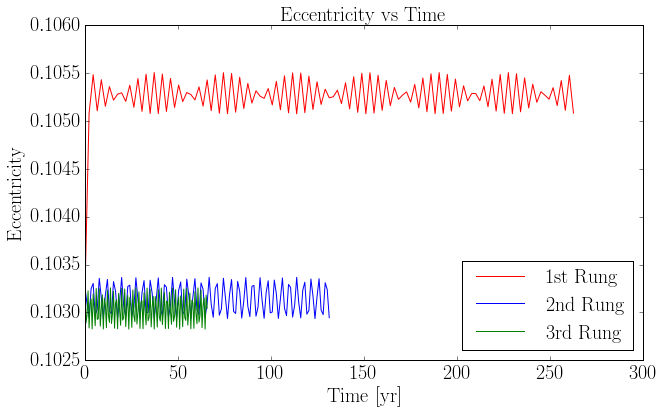

In [23]:
plt.plot(time_1,ecc_1,color='red',label="1st Rung")
plt.plot(time_2,ecc_2,color='blue',label="2nd Rung")
plt.plot(time_3,ecc_3,color='green',label="3rd Rung")
plt.xlabel("Time [yr]")
plt.ylabel("Eccentricity")
plt.title("Eccentricity vs Time")
plt.legend(loc="lower right")
#plt.savefig("eccBinaryTest.pdf")

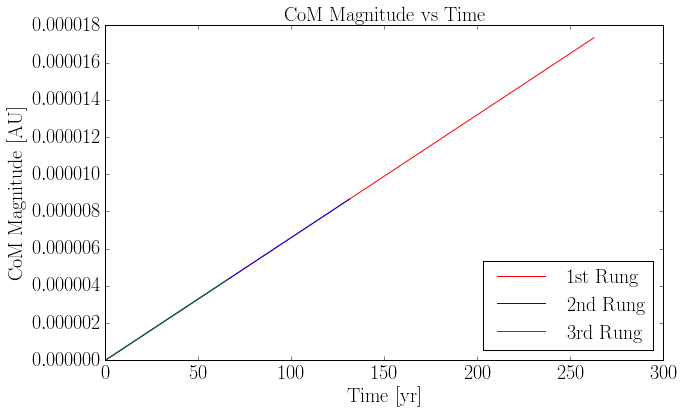

In [24]:
plt.plot(time_1,com_1,color='red',label="1st Rung")
plt.plot(time_2,com_2,color='blue',label="2nd Rung")
plt.plot(time_3,com_3,color='green',label="3rd Rung")
plt.xlabel("Time [yr]")
plt.ylabel("CoM Magnitude [AU]")
plt.title("CoM Magnitude vs Time")
plt.legend(loc="lower right")
#plt.savefig("comBinaryTest.pdf")